In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import os
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential
from tensorflow.python.keras import backend as K

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.11.0
Num GPUs Available:  0


In [3]:
sess = tf.compat.v1.Session()
K.set_session(sess)

In [4]:
train_data = keras.utils.image_dataset_from_directory(
    directory = 'images/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 120,
    image_size = (224, 224)
)

Found 28709 files belonging to 7 classes.


In [5]:
validation_data = keras.utils.image_dataset_from_directory(
    directory = 'images/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 120,
    image_size = (224, 224)
)

Found 7178 files belonging to 7 classes.


2024-12-01 00:41:22.085434: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


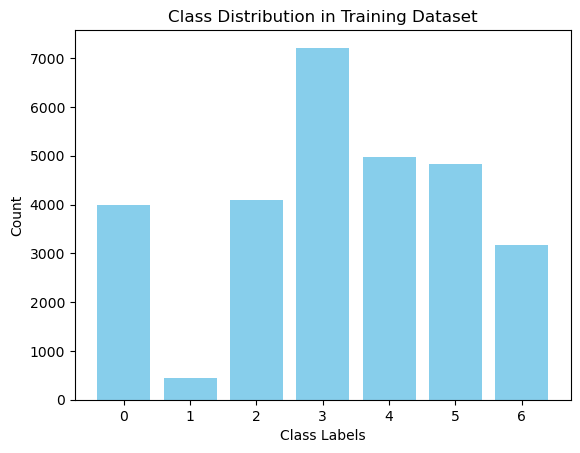

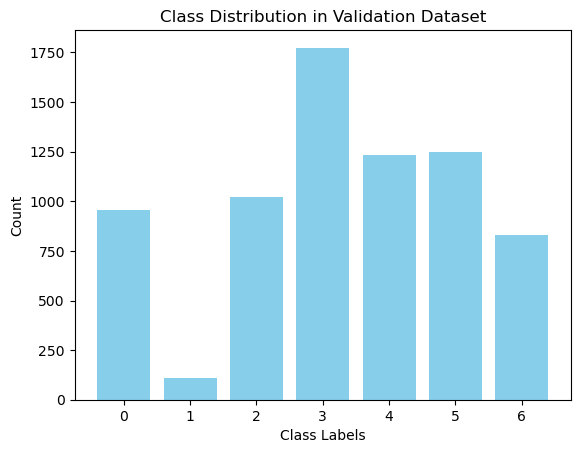

In [6]:
def plot_distribution(dataset, title):
    labels = []
    for _, label in dataset.unbatch():
        labels.append(label.numpy())  # Append the scalar value
    
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color='skyblue')
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# Plot initial class distribution
plot_distribution(train_data, "Class Distribution in Training Dataset")
plot_distribution(validation_data, "Class Distribution in Validation Dataset")

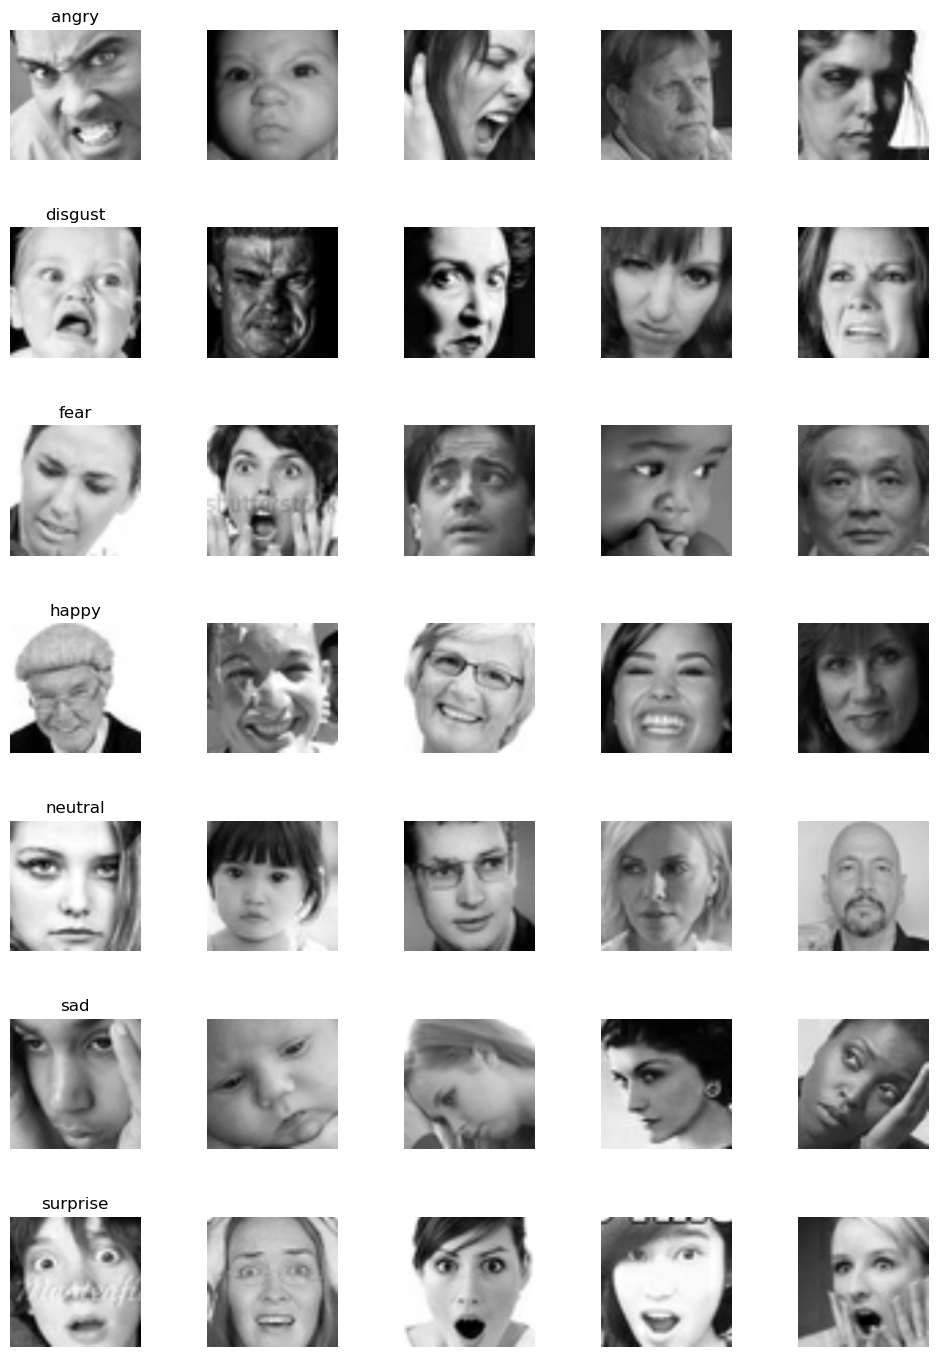

In [7]:
def plot_images_by_class(dataset, class_names, num_images_per_class=5):
    """
    Plot a few sample images for each class from the dataset.
    
    :param dataset: The dataset to sample from.
    :param class_names: List of class names corresponding to labels.
    :param num_images_per_class: Number of images to display per class.
    """
    # Create a dictionary to store images for each class
    images_by_class = {class_label: [] for class_label in range(len(class_names))}

    for image, label in dataset.unbatch():
        label = label.numpy()
        if len(images_by_class[label]) < num_images_per_class:
            images_by_class[label].append(image.numpy())
        if all(len(images) == num_images_per_class for images in images_by_class.values()):
            break

    # Plot images with a smaller figure size
    fig, axs = plt.subplots(len(class_names), num_images_per_class, figsize=(10, 2 * len(class_names)))  # Reduced figsize
    fig.tight_layout()

    for class_label, images in images_by_class.items():
        for i, img in enumerate(images):
            ax = axs[class_label, i] if len(class_names) > 1 else axs[i]
            ax.imshow(img.astype("uint8"))
            ax.axis("off")
            if i == 0:
                ax.set_title(class_names[class_label])

    plt.show()

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_images_by_class(train_data, class_names)

In [8]:
def Normalize(image, label):
  image = tf.cast(image/255.0, tf.float32)
  return image,label

validate = validation_data.map(Normalize)

In [9]:
def data_augmentation(X, y, df, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1,
                      brightness_range=(0.95, 1.05), horizontal_flip=True, vertical_flip=True, fill_mode='nearest', target_count=None):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        brightness_range=brightness_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        fill_mode=fill_mode
    )

    balanced_X = []
    balanced_y = []

    target_count = target_count if target_count else max(df['emotion'].value_counts())

    distribution = []

    for class_label in df['emotion'].unique():
        # Find the indices of the images belonging to the current class
        class_indices = np.where(y == class_label)[0]  # Corrected: no need for one-hot indexing
        class_images = X[class_indices]
        class_labels = y[class_indices]
        num_images = class_images.shape[0]
        distribution.append(num_images)

        # Calculate how many augmentations are needed for this class
        augmentations_needed = target_count - num_images

        # Augment images until we reach the target count
        while augmentations_needed > 0:
            for img, label in zip(class_images, class_labels):
                if augmentations_needed <= 0:
                    break
                img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)
                label = label.reshape((1,))  # Reshape to a single label
                augmented_img = next(datagen.flow(img))  # Generate an augmented image
                balanced_X.append(augmented_img.squeeze())  # Add augmented image to list
                balanced_y.append(label.squeeze())  # Add label to list
                augmentations_needed -= 1

        # Add the original images for this class to the balanced dataset
        balanced_X.extend(class_images)
        balanced_y.extend(class_labels)

    balanced_X = np.array(balanced_X)
    balanced_y = np.array(balanced_y)

    return balanced_X, balanced_y, distribution

In [10]:
# Extract data from train dataset
def extract_images_and_labels(dataset):
    X, y = [], []
    for image, label in dataset.unbatch():
        X.append(image.numpy())
        y.append(label.numpy())
    return np.array(X), np.array(y)

# Assuming train_data is loaded correctly
train_images, train_labels = extract_images_and_labels(train_data)

In [11]:
df_train = pd.DataFrame({'image': np.arange(len(train_labels)), 'emotion': train_labels})

In [12]:
# Apply data augmentation to balance the dataset
balanced_X, balanced_y, distribution = data_augmentation(
    train_images, 
    train_labels, 
    df_train, 
    target_count=4000
)

In [13]:
import numpy as np

In [15]:
balanced_X.shape

(33107, 224, 224, 3)

In [16]:
from collections import Counter

In [17]:
# Original distribution
original_distribution = Counter(train_labels)
print("Original distribution:", original_distribution)

# Augmented distribution
balanced_distribution = Counter(balanced_y)
print("Balanced distribution:", balanced_distribution)

# Verify that the augmented distribution matches the target count
target_count = max(original_distribution.values())

Original distribution: Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 3995, 6: 3171, 1: 436})
Balanced distribution: Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 4000, 6: 4000, 1: 4000})


In [18]:
# Convert augmented data back to TensorFlow Dataset
balanced_train_data = tf.data.Dataset.from_tensor_slices((balanced_X, balanced_y))
balanced_train_data = balanced_train_data.cache().shuffle(buffer_size=1000).batch(120).prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
num_classes = 7

In [25]:
import os.path
model_file = "my_model.keras"
'''
if os.path.isfile(model_file):
    print(f"Loaded existing model: {model_file}")
    model = tf.keras.models.load_model(model_file)
'''
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)))
model.add(tf.keras.layers.Resizing(48, 48))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [27]:
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resizing (Resizing)         (None, 48, 48, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 64)        0         
                                                      

In [29]:
history = model.fit(balanced_train_data, epochs=20, validation_data=validate)

Epoch 1/20
276/276 [==============================] - 91s 326ms/step - loss: 33.6158 - accuracy: 0.5719 - val_loss: 3.6549 - val_accuracy: 0.0155
Epoch 2/20
276/276 [==============================] - 89s 322ms/step - loss: 1.2187 - accuracy: 0.5382 - val_loss: 2.9931 - val_accuracy: 0.0155
Epoch 3/20
276/276 [==============================] - 90s 324ms/step - loss: 2.0060 - accuracy: 0.0150 - val_loss: 1.9387 - val_accuracy: 0.2471
Epoch 4/20
276/276 [==============================] - 89s 320ms/step - loss: 1.9564 - accuracy: 0.1428 - val_loss: 1.9318 - val_accuracy: 0.2471
Epoch 5/20
276/276 [==============================] - 93s 336ms/step - loss: 1.9517 - accuracy: 0.2179 - val_loss: 1.9262 - val_accuracy: 0.2471
Epoch 6/20
276/276 [==============================] - 96s 347ms/step - loss: 1.9483 - accuracy: 0.2179 - val_loss: 1.9217 - val_accuracy: 0.2471
Epoch 7/20
276/276 [==============================] - 90s 327ms/step - loss: 1.9457 - accuracy: 0.2179 - val_loss: 1.9180 - val_a

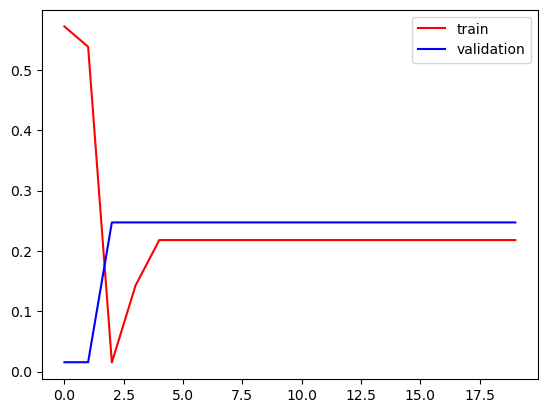

In [30]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

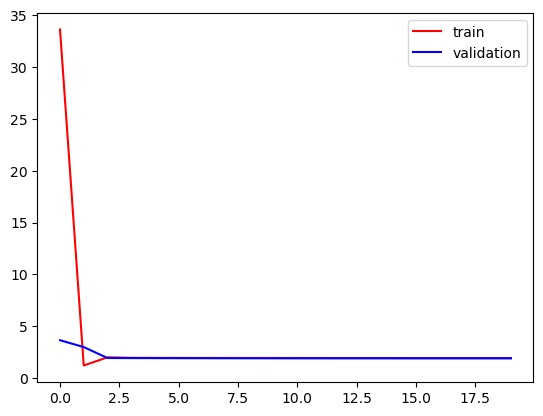

In [31]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()